# Quantum Neural Network for FinTech Time Series Function Fitting

Using the example from Penny Lane of a variational circuit that learns a
fit for a one-dimensional function, we generate several examples of functions with noise
and train the quantum neural network to fit them. 

The variational circuit used is the continuous-variable quantum neural
network model described in:

`Killoran et al. (2018) <https://arxiv.org/abs/1806.06871>`


In [1]:
# Import PennyLane, the wrapped version of NumPy provided by PennyLane,and an optimizer.
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

In [2]:
# Other imports:
# matplotlib.pyplot to plot and visualize the data
# numpy to generate the mathematical function
# pylab to help with interactive plots
# pickle to dump the data into a file for future use
import matplotlib.pyplot as plt
import numpy as np
import pylab
import pickle

In [3]:
from dateutil.parser import parse 
import matplotlib as mpl
import seaborn as sns
import pandas as pd

## Time Series Drug Sales Data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [5]:
# Rescale the data
X = (df.index-100)/25
Y = df.value/15 - 1

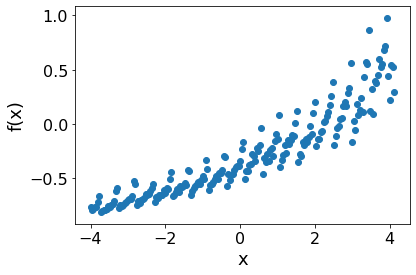

In [6]:
plt.figure()
plt.scatter(X, Y)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.show()

In [7]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

### Quantum node
For a single quantum mode, each layer of the variational circuit is defined as:

In [8]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into
the displacement of the mode, and then executes the layers. The output
is the expectation of the x-quadrature.

In [9]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

### Objective
As an objective we take the square loss between target labels and model
predictions.

In [10]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In the cost function, we compute the outputs from the variational
circuit. Function fitting is a regression problem, and we interpret the
expectations from the quantum node as predictions (i.e., without
applying postprocessing such as thresholding).


In [11]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x) for x in features]
    return square_loss(labels, preds)

The network’s weights (called ``var`` here) are initialized with values
sampled from a normal distribution. We use 6 layers.

In [12]:
np.random.seed(0)
num_layers = 6
var_init = 0.05 * np.random.randn(num_layers, 5)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]
 [-0.12764949  0.03268093  0.04322181 -0.03710825  0.11348773]
 [-0.07271828  0.00228793 -0.00935919  0.07663896  0.07346794]]


In [13]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(500):
    var = opt.step(lambda v: cost(v, X, Y), var)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X, Y)))

Iter:     1 | Cost: 1.0918091 
Iter:     2 | Cost: 0.8614335 
Iter:     3 | Cost: 0.7124058 
Iter:     4 | Cost: 0.6136188 
Iter:     5 | Cost: 0.5472918 
Iter:     6 | Cost: 0.5023930 
Iter:     7 | Cost: 0.4717386 
Iter:     8 | Cost: 0.4504651 
Iter:     9 | Cost: 0.4351745 
Iter:    10 | Cost: 0.4234362 
Iter:    11 | Cost: 0.4134862 
Iter:    12 | Cost: 0.4040411 
Iter:    13 | Cost: 0.3941809 
Iter:    14 | Cost: 0.3832761 
Iter:    15 | Cost: 0.3709416 
Iter:    16 | Cost: 0.3570077 
Iter:    17 | Cost: 0.3415017 
Iter:    18 | Cost: 0.3246319 
Iter:    19 | Cost: 0.3067701 
Iter:    20 | Cost: 0.2884246 
Iter:    21 | Cost: 0.2702021 
Iter:    22 | Cost: 0.2527540 
Iter:    23 | Cost: 0.2367136 
Iter:    24 | Cost: 0.2226299 
Iter:    25 | Cost: 0.2109098 
Iter:    26 | Cost: 0.2017781 
Iter:    27 | Cost: 0.1952625 
Iter:    28 | Cost: 0.1912017 
Iter:    29 | Cost: 0.1892754 
Iter:    30 | Cost: 0.1890455 
Iter:    31 | Cost: 0.1900046 
Iter:    32 | Cost: 0.1916267 
Iter:   

Finally, we collect the predictions of the trained model for 50 values
in the range $[-1,3]$:

In [24]:
x_pred = np.linspace(-1, 3, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

and plot the shape of the function that the model has “learned” from
the noisy data (red dots).

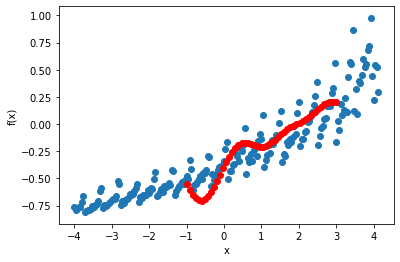

In [25]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color="red")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

Extending the interval predicted by the model shows a drop in accuracy, which is to be expected. 

In [28]:
x_pred = np.linspace(-3, 4, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

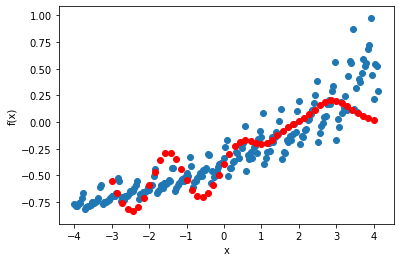

In [29]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color="red")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

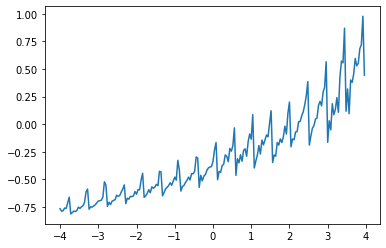

In [16]:
plt.plot(X[0:200], Y[0:200])

Although this prediction may at first seem inaccurate, when we look at the time span of the data and notice that the model has learned a function that spans several years worth of drug sales data, extending the predictive range by several years by extending the interval $[-1, 3]$ out to $[-3, 4]$ is inevitably going to decrease accuracy in the function fitting. 

We can use PennyLane to look at typical functions that the
model produces without being trained at all. The shape of these
functions varies significantly with the variance hyperparameter for the
weight initialization.

Setting this hyperparameter to a small value produces almost linear
functions, since all quantum gates in the variational circuit
approximately perform the identity transformation in that case. Larger
values produce smoothly oscillating functions with a period that depends
on the number of layers used (generically, the more layers, the smaller
the period).

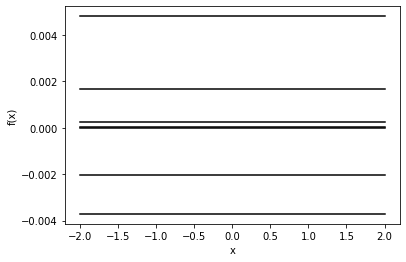

In [19]:
variance = 1.0

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x=x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color="black")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

## References
PennyLane "Function Fitting with a Quantum Neural Network" 
```
https://pennylane.ai/qml/app/quantum_neural_net.html
```

"Generating and visualizing data from a sine wave in Python" 
```
https://goelhardik.github.io/2016/05/25/sampling-sine-wave/
```

"Continuous-variable quantum neural networks, Killoran et al. (2018)" 
```
https://arxiv.org/abs/1806.06871>
```

"adding noise to a signal in python" 
```
https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python
```

"Making A Matplotlib Scatterplot From A Pandas Dataframe"
```
https://chrisalbon.com/python/data_visualization/matplotlib_scatterplot_from_pandas/
```

"Time Series Analysis in Python – A Comprehensive Guide with Examples"
```
https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a
```